In [14]:
import numpy as np                  
from scipy.spatial import distance  
import cvxopt                       
import copy 
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris, load_breast_cancer, load_digits
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

%matplotlib inline

In [15]:
#Kernel functions: linear, polynomial and gaussian

def gaussian_SMO(u, v):
        v = v[np.newaxis, :] if np.ndim(v) == 1 else v
        u = u[np.newaxis, :] if np.ndim(u) == 1 else u

        dist_squared = np.squeeze(np.linalg.norm(u[:, :, np.newaxis] - v.T[np.newaxis, :, :], axis=1) ** 2)

        return np.exp(1.0 * dist_squared)

def gaussian_cvxopt(x, xࠤ):
    return np.exp(-10 * distance.cdist(x, xࠤ, 'sqeuclidean'))

kernel_funs = {
    'linear': lambda x, xࠤ , c=0: x @ xࠤ .T, 
    'polynomial': lambda x, xࠤ , Q=5: (x @ xࠤ.T)**2, 
    'gaussian': lambda x, xࠤ, k=1.0: gaussian_cvxopt(x, xࠤ) if k != 1 else gaussian_SMO(x, xࠤ)
    }

In [16]:
class SVM:
    def __init__(self, kernel: str='linear', C: int=1, k: int=2):
        self.kernel_str = kernel
        self.kernel = kernel_funs[kernel] 
        self.C = C                  
        self.k = k                 
        self.X, y = None, None
        self.αs = None
        self.multiclass = False
        self.clfs = []    
    
    def fit(self, X, y):
        if len(np.unique(y)) > 2:
            self.multiclass = True
            return self.multi_fit(X, y)
        
        if set(np.unique(y)) == {0, 1}: y[y == 0] = -1

        self.y = y.reshape(-1, 1).astype(np.double) 
        self.X = X
        N = X.shape[0]
        
        self.K = self.kernel(X, X, self.k)
        
        P = cvxopt.matrix(self.y @ self.y.T * self.K)
        q = cvxopt.matrix(-np.ones((N, 1)))
 
        A = cvxopt.matrix(self.y.T)
        b = cvxopt.matrix(np.zeros(1))

        G = cvxopt.matrix(np.vstack((-np.identity(N),
                                    np.identity(N))))
        h = cvxopt.matrix(np.vstack((np.zeros((N,1)),
                                    np.ones((N,1)) * self.C)))
          
        cvxopt.solvers.options['show_progress'] = False
        sol = cvxopt.solvers.qp(P, q, G, h, A, b)
        self.αs = np.array(sol["x"])

        self.is_sv = ((self.αs > 1e-3) & (self.αs <= self.C)).squeeze()
        self.margin_sv = np.argmax((1e-3 < self.αs) & (self.αs < self.C - 1e-3))
    
    def multi_fit(self, X, y):
        self.k = len(np.unique(y))     
        for i in range(self.k):
            Xs, Ys = X, copy.copy(y)
            Ys[Ys!=i], Ys[Ys==i] = -1, +1
      
            clf = SVM(kernel=self.kernel_str, C=self.C, k=self.k)
            clf.fit(Xs, Ys)
        
            self.clfs.append(clf)

    def predict(self, X_t):
        if self.multiclass: return self.multi_predict(X_t)
        xₛ, yₛ = self.X[self.margin_sv, np.newaxis], self.y[self.margin_sv]
        αs, y, X= self.αs[self.is_sv], self.y[self.is_sv], self.X[self.is_sv]

        b = yₛ - np.sum(αs * y * self.kernel(X, xₛ, self.k), axis=0)
        score = np.sum(αs * y * self.kernel(X, X_t, self.k), axis=0) + b
        return np.sign(score).astype(int), score 
    
    def multi_predict(self, X):
        preds = np.zeros((X.shape[0], self.k))
        for i, clf in enumerate(self.clfs):
            _, preds[:, i] = clf.predict(X)
     
        return np.argmax(preds, axis=1)

In [17]:
class SVM_SMO():
    def __init__(self, c = 1.0, kkt_thr = 1e-3, max_iter = 1e4, kernel = "linear", kernel_var = 1.0):
        self.c = float(c)
        self.max_iter = max_iter
        self.kkt_thr = kkt_thr
        self.kernel = kernel_funs[kernel]
        self.b = np.array([])  
        self.alpha = np.array([])  
        self.support_vectors = np.array([])  
        self.support_labels = np.array([])  
        self.kernel_var = kernel_var

    def predict(self,x) :
        w = self.support_labels * self.alpha
        x = self.kernel(self.support_vectors, x)

        scores = np.dot(w, x) + self.b
        pred = np.sign(scores)

        return pred, scores

    def fit(self, x_train, y_train):

        N, _ = x_train.shape
        self.b = 0
        self.alpha = np.zeros(N)
        self.support_vectors = x_train
        self.support_labels = y_train
        
        iter_idx = 0
        non_kkt_array = np.arange(N)  
        error_cache = self.predict(x_train)[1] - y_train  

        while iter_idx < self.max_iter:
            i_2, non_kkt_array = self.i2_heuristic(non_kkt_array)
            if i_2 == -1: break

            i_1 = self.i1_heuristic(i_2, error_cache)

            if i_1 == i_2: continue
            
            x_1, y_1, alpha_1 = self.support_vectors[i_1, :], self.support_labels[i_1], self.alpha[i_1]
            x_2, y_2, alpha_2 = self.support_vectors[i_2, :], self.support_labels[i_2], self.alpha[i_2]
            
            L, H = self.compute_boundaries(alpha_1, alpha_2, y_1, y_2)
            if L == H: continue
            
            eta = self.compute_eta(x_1, x_2)
            if eta == 0: continue

            _, score_1 = self.predict(x_1)
            _, score_2 = self.predict(x_2)

            E_1 = score_1 - y_1
            E_2 = score_2 - y_2

            alpha_2_new = alpha_2 + y_2 * (E_1 - E_2) / eta
            alpha_2_new = np.minimum(alpha_2_new, H)
            alpha_2_new = np.maximum(alpha_2_new, L)

            alpha_1_new = alpha_1 + y_1*y_2*(alpha_2 - alpha_2_new)

            self.compute_b(alpha_1_new, alpha_2_new, E_1, E_2, i_1, i_2)
        
            self.alpha[i_1] = alpha_1_new
            self.alpha[i_2] = alpha_2_new

            error_cache[i_1] = self.predict(x_1)[1] - y_1
            error_cache[i_2] = self.predict(x_2)[1] - y_2

            iter_idx = iter_idx + 1

        support_vectors_idx = (self.alpha != 0)
        self.support_labels = self.support_labels[support_vectors_idx]
        self.support_vectors = self.support_vectors[support_vectors_idx, :]
        self.alpha = self.alpha[support_vectors_idx]

    def i1_heuristic(self, i_2, error_cache):
        E_2 = error_cache[i_2]

        non_bounded_idx = np.argwhere((0 < self.alpha) & (self.alpha < self.c)).reshape((1, -1))[0]

        if non_bounded_idx.shape[0] > 0:
            if E_2 >= 0:
                i_1 = non_bounded_idx[np.argmin(error_cache[non_bounded_idx])]
            else:
                i_1 = non_bounded_idx[np.argmax(error_cache[non_bounded_idx])]
        else:
            i_1 = np.argmax(np.abs(error_cache - E_2))

        return i_1

    def i2_heuristic(self, non_kkt_array):
        i_2 = -1

        for idx in non_kkt_array:
            non_kkt_array = np.delete(non_kkt_array, np.argwhere(non_kkt_array == idx))

            if not self.check_kkt(idx):
                i_2 = idx
                break

        if i_2 == -1:
            idx_array = np.arange(self.alpha.shape[0])
            non_kkt_array = idx_array[~(self.check_kkt(idx_array))]
            
            if non_kkt_array.shape[0] > 0:
                np.random.shuffle(non_kkt_array)
                i_2 = non_kkt_array[0]
                non_kkt_array = non_kkt_array[1:-1]

        return i_2, non_kkt_array

    def check_kkt(self, check_idx):
        alpha_idx = self.alpha[check_idx]
        _, score_idx = self.predict(self.support_vectors[check_idx, :])
        y_idx = self.support_labels[check_idx]
        r_idx = y_idx * score_idx - 1
        cond_1 = (alpha_idx < self.c) & (r_idx < - self.kkt_thr)
        cond_2 = (alpha_idx > 0) & (r_idx > self.kkt_thr)

        return ~(cond_1 | cond_2)

    def compute_boundaries(self, alpha_1, alpha_2, y_1,y_2):
        if y_1 == y_2:
            lb = np.max([0, alpha_1 + alpha_2 - self.c])
            ub = np.min([self.c, alpha_1 + alpha_2])
        else:
            lb = np.max([0, alpha_2 - alpha_1])
            ub = np.min([self.c, self.c + alpha_2 - alpha_1])
        return lb, ub

    def compute_eta( self, x_1, x_2):
        return self.kernel(x_1, x_1) + self.kernel(x_2, x_2) - 2*self.kernel(x_1, x_2)

    def compute_b(self, alpha_1_new, alpha_2_new, E_1, E_2, i_1,i_2) :
        x_1 = self.support_vectors[i_1]
        x_2 = self.support_vectors[i_2]

        b1 = self.b - E_1 - self.support_labels[i_1] * (alpha_1_new - self.alpha[i_1]) * self.kernel(x_1, x_1) - \
            self.support_labels[i_2] * (alpha_2_new - self.alpha[i_2]) * self.kernel(x_1, x_2)

        b2 = self.b - E_2 - self.support_labels[i_1] * (alpha_1_new - self.alpha[i_1]) * self.kernel(x_1, x_2) - \
            self.support_labels[i_2] * (alpha_2_new - self.alpha[i_2]) * self.kernel(x_2, x_2)

        if 0 < alpha_1_new < self.c:
            self.b = b1
        elif 0 < alpha_2_new < self.c:
            self.b = b2
        else:
            self.b = np.mean([b1, b2])

SVM with SMO

Kernel: linear
Test accuracy for linear kernel: 0.87

Kernel: polynomial
Test accuracy for polynomial kernel: 0.87

Kernel: gaussian
Test accuracy for gaussian kernel: 0.17

---------------------------------------------

SVM using cvxopt

Kernel: linear
Test accuracy for linear kernel: 0.87

Kernel: polynomial
Test accuracy for polynomial kernel: 1.00

Kernel: gaussian
Test accuracy for gaussian kernel: 0.93



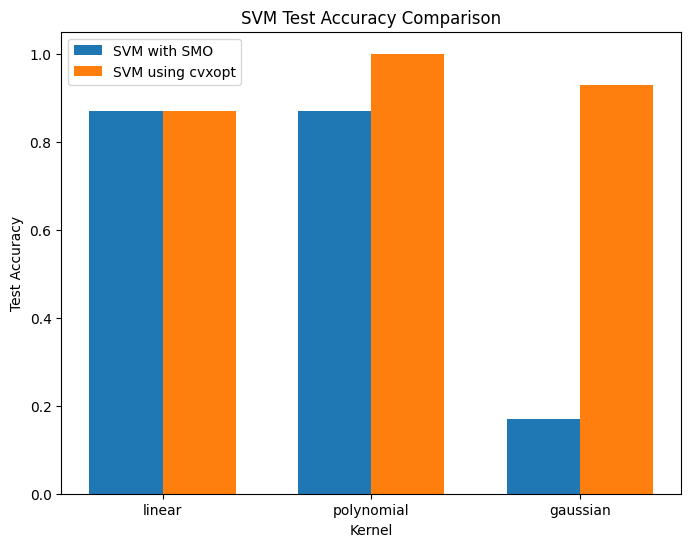

In [18]:
#SVM test with Iris dataset

X, y = load_iris(return_X_y=True)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

print("SVM with SMO\n")

svm_smo = {}
svm_cvxopt = {}

for i in range(2):
    for kernel in kernel_funs.keys():
        print(f"Kernel: {kernel}")
        svm = SVM_SMO(kernel=kernel) if i == 0 else SVM(kernel=kernel)
        svm.fit(X_train, y_train)

        y_pred = svm.predict(X_test)

        if i == 0:
            svm_smo[kernel] = round(np.sum(y_test==y_pred)/y_test.shape[0], 2)
        else:
            svm_cvxopt[kernel] = round(np.sum(y_test==y_pred)/y_test.shape[0], 2)

        print(f"Test accuracy for {kernel} kernel: {np.sum(y_test==y_pred)/y_test.shape[0]:.2f}\n")

    if i == 0:    
        print('---------------------------------------------')
        print("\nSVM using cvxopt\n")

#Plot testing accuracy for both SVM with SMO and SVM using cvxopt

fig, ax = plt.subplots(figsize=(8, 6))

x = list(range(len(svm_smo)))
width = 0.35

ax.bar([i - width/2 for i in x], list(svm_smo.values()), width, label='SVM with SMO')
ax.bar([i + width/2 for i in x], list(svm_cvxopt.values()), width, label='SVM using cvxopt')

ax.set_xticks(x)
ax.set_xticklabels(list(svm_smo.keys()))

ax.set_xlabel('Kernel')
ax.set_ylabel('Test Accuracy')
ax.set_title('SVM Test Accuracy Comparison')
ax.legend()



SVM with SMO

Kernel: linear
Test accuracy for linear kernel: 0.63

Kernel: polynomial
Test accuracy for polynomial kernel: 0.63

Kernel: gaussian
Test accuracy for gaussian kernel: 0.74

---------------------------------------------

SVM using cvxopt

Kernel: linear
Test accuracy for linear kernel: 0.63

Kernel: polynomial
Test accuracy for polynomial kernel: 0.00

Kernel: gaussian
Test accuracy for gaussian kernel: 0.63



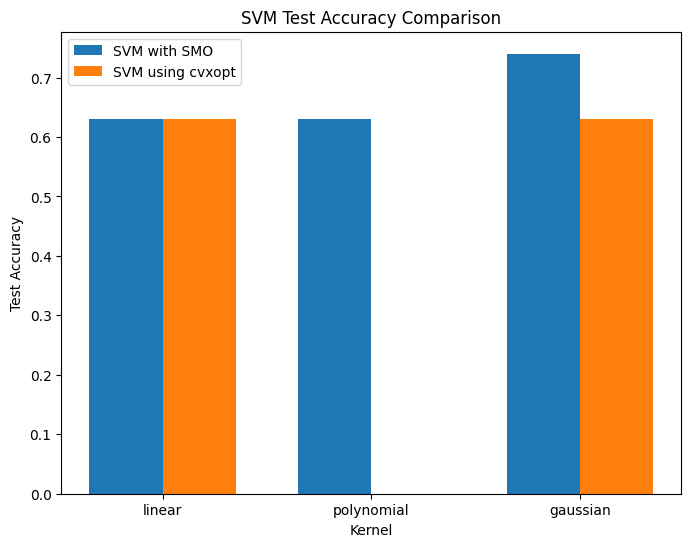

In [19]:
#SVM test with Breast Cancer dataset

X, y = load_breast_cancer(return_X_y=True)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

print("SVM with SMO\n")

svm_smo = {}
svm_cvxopt = {}

for i in range(2):
    for kernel in kernel_funs.keys():
        print(f"Kernel: {kernel}")
        svm = SVM_SMO(kernel=kernel) if i == 0 else SVM(kernel=kernel)
        svm.fit(X_train, y_train)

        y_pred = svm.predict(X_test)

        if i == 0:
            svm_smo[kernel] = round(np.sum(y_test==y_pred)/y_test.shape[0], 2)
        else:
            svm_cvxopt[kernel] = round(np.sum(y_test==y_pred)/y_test.shape[0], 2)

        print(f"Test accuracy for {kernel} kernel: {np.sum(y_test==y_pred)/y_test.shape[0]:.2f}\n")

    if i == 0:    
        print('---------------------------------------------')
        print("\nSVM using cvxopt\n")

#Plot testing accuracy for both SVM with SMO and SVM using cvxopt

fig, ax = plt.subplots(figsize=(8, 6))

x = list(range(len(svm_smo)))
width = 0.35

ax.bar([i - width/2 for i in x], list(svm_smo.values()), width, label='SVM with SMO')
ax.bar([i + width/2 for i in x], list(svm_cvxopt.values()), width, label='SVM using cvxopt')

ax.set_xticks(x)
ax.set_xticklabels(list(svm_smo.keys()))

ax.set_xlabel('Kernel')
ax.set_ylabel('Test Accuracy')
ax.set_title('SVM Test Accuracy Comparison')
ax.legend()


SVM with SMO

Kernel: linear


Test accuracy for linear kernel: 0.10

Kernel: polynomial
Test accuracy for polynomial kernel: 0.10

Kernel: gaussian
Test accuracy for gaussian kernel: 0.24

---------------------------------------------

SVM using cvxopt

Kernel: linear
Test accuracy for linear kernel: 0.94

Kernel: polynomial
Test accuracy for polynomial kernel: 0.11

Kernel: gaussian
Test accuracy for gaussian kernel: 0.08



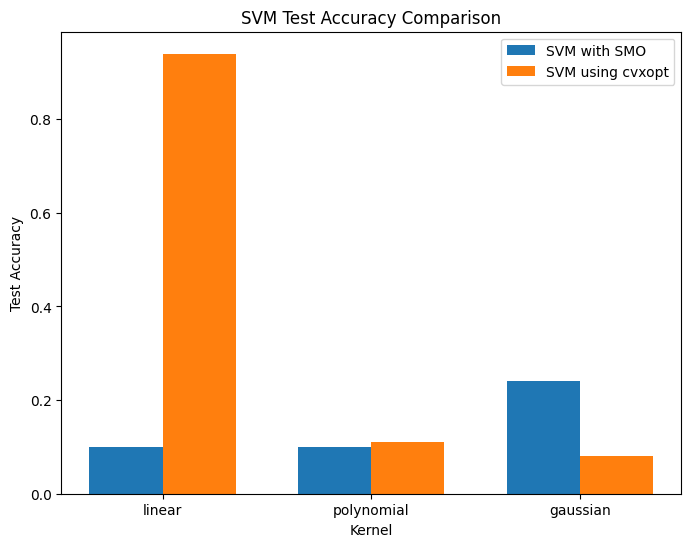

In [20]:
#SVM test with Digits dataset

X, y = load_digits(return_X_y=True)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

print("SVM with SMO\n")

svm_smo = {}
svm_cvxopt = {}

for i in range(2):
    for kernel in kernel_funs.keys():
        print(f"Kernel: {kernel}")
        svm = SVM_SMO(kernel=kernel) if i == 0 else SVM(kernel=kernel)
        svm.fit(X_train, y_train)

        y_pred = svm.predict(X_test)

        if i == 0:
            svm_smo[kernel] = round(np.sum(y_test==y_pred)/y_test.shape[0], 2)
        else:
            svm_cvxopt[kernel] = round(np.sum(y_test==y_pred)/y_test.shape[0], 2)

        print(f"Test accuracy for {kernel} kernel: {np.sum(y_test==y_pred)/y_test.shape[0]:.2f}\n")

    if i == 0:    
        print('---------------------------------------------')
        print("\nSVM using cvxopt\n")

#Plot testing accuracy for both SVM with SMO and SVM using cvxopt

fig, ax = plt.subplots(figsize=(8, 6))

x = list(range(len(svm_smo)))
width = 0.35

ax.bar([i - width/2 for i in x], list(svm_smo.values()), width, label='SVM with SMO')
ax.bar([i + width/2 for i in x], list(svm_cvxopt.values()), width, label='SVM using cvxopt')

ax.set_xticks(x)
ax.set_xticklabels(list(svm_smo.keys()))

ax.set_xlabel('Kernel')
ax.set_ylabel('Test Accuracy')
ax.set_title('SVM Test Accuracy Comparison')
ax.legend()
